In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
import random
from datetime import datetime

In [2]:
df_1 = pd.read_csv('train.csv')
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [3]:
#number of rows i want in the train and test dataframes
rowNum = 20000

testIdx = []
trainIdx = []

#randomly pick the indexes from each dataframe that will go into the train and test dataframes
while len(trainIdx) < rowNum:
    num = random.randint(0, len(df_1)-1)
    if not num in trainIdx:
        trainIdx.append(num)

while len(testIdx) < rowNum:
    num = random.randint(0, len(df_1)-1)
    if not num in testIdx:
        testIdx.append(num)

In [4]:
trainDF = df_1.iloc[trainIdx].reset_index(drop=True)
testDF = df_1.iloc[testIdx].reset_index(drop=True)

In [5]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Radius of the Earth in kilometers (you can change it to miles if needed)
    radius_earth_km = 6371.0

    # Calculate the distance
    distance = radius_earth_km * c

    return distance

In [6]:
# # Example coordinates (latitude and longitude) for two points
# latitude1, longitude1 = 40.767937, -73.982155
# latitude2, longitude2 = 40.765602, -73.964630

# # Calculate the distance
# distance_km = haversine_distance(latitude1, longitude1, latitude2, longitude2)

# print(f"The distance between the two points is {distance_km:.2f} kilometers.")

In [7]:
distCol = []
timeInMinCol = []

for i in range(len(trainDF)):
    latitude1, longitude1 = trainDF.at[i, 'pickup_latitude'], trainDF.at[i, 'pickup_longitude']
    latitude2, longitude2 = trainDF.at[i, 'dropoff_latitude'], trainDF.at[i, 'dropoff_longitude']
    
    distance = round(haversine_distance(latitude1, longitude1, latitude2, longitude2), 2)
    time = round(trainDF.at[i, 'trip_duration']/60, 3)
    
    distCol.append(distance)
    timeInMinCol.append(time)

trainDF['totalDist_km'] = distCol
trainDF['timeInMin'] = timeInMinCol

distCol.clear()
timeInMinCol.clear()

for i in range(len(testDF)):
    latitude1, longitude1 = testDF.at[i, 'pickup_latitude'], testDF.at[i, 'pickup_longitude']
    latitude2, longitude2 = testDF.at[i, 'dropoff_latitude'], testDF.at[i, 'dropoff_longitude']
    
    distance = round(haversine_distance(latitude1, longitude1, latitude2, longitude2), 2)
    time = round(testDF.at[i, 'trip_duration']/60, 3)
    
    distCol.append(distance)
    timeInMinCol.append(time)

testDF['totalDist_km'] = distCol
testDF['timeInMin'] = timeInMinCol

In [8]:
trainDF['season'] = 'unknown'
testDF['season'] = 'unknown'

#seasons and their [start,end] days of the year

spring = [79,172]
summer = [173,266]
fall = [267, 354]
winter = [356,78]

def calcSeason(day):
    if day > spring[0] and day < spring[1]:
        return 'spring'
    elif day > summer[0] and day < summer[1]:
        return 'summer'
    elif day > fall[0] and day < fall[1]:
        return 'fall'
    else:
        return 'winter'

for i in range(len(trainDF)):
    date_format = '%Y-%m-%d %H:%M:%S'
    date = datetime.strptime(trainDF.loc[i,'pickup_datetime'], date_format)
    day = date.timetuple().tm_yday
    season = calcSeason(day)
    trainDF.loc[i, 'season'] = season
    
for i in range(len(testDF)):
    date_format = '%Y-%m-%d %H:%M:%S'
    date = datetime.strptime(testDF.loc[i,'pickup_datetime'], date_format)
    day = date.timetuple().tm_yday
    season = calcSeason(day)
    testDF.loc[i, 'season'] = season

In [9]:
#drops datapoins that are percieved outliers

idxToDrop = []
for i in range(len(trainDF)):
    if trainDF.loc[i, 'timeInMin'] > 200:
        idxToDrop.append(i)
    elif trainDF.loc[i, 'totalDist_km'] > 50:
        idxToDrop.append(i)
trainDF_dropped = trainDF.drop(idxToDrop)
trainDF_dropped = trainDF_dropped.reset_index(drop=True)

idxToDrop.clear()
for i in range(len(testDF)):
    if testDF.loc[i, 'timeInMin'] > 200:
        idxToDrop.append(i)
    elif testDF.loc[i, 'totalDist_km'] > 50:
        idxToDrop.append(i)
testDF_dropped = testDF.drop(idxToDrop)
testDF_dropped = testDF_dropped.reset_index(drop=True)

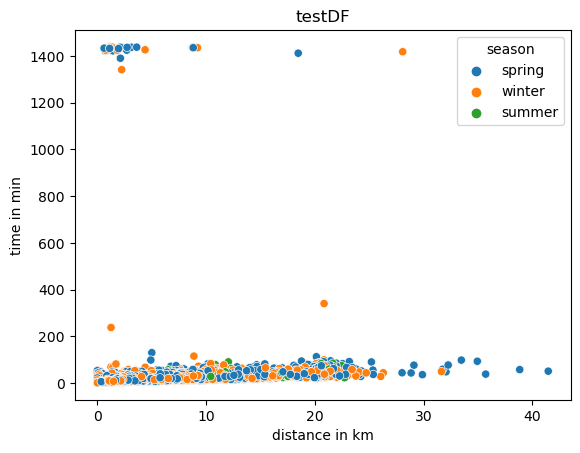

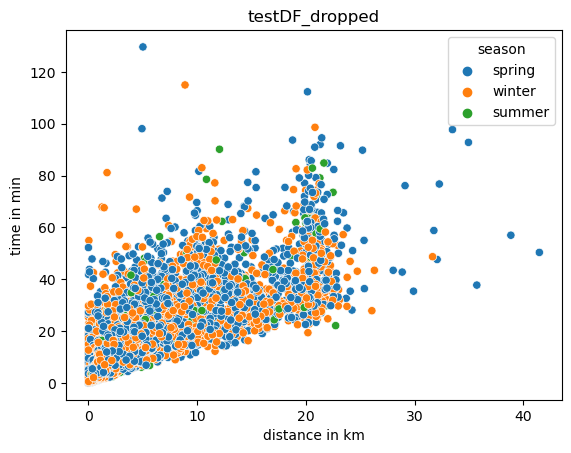

In [10]:
sns.scatterplot(x=testDF['totalDist_km'], y=testDF['timeInMin'], hue=testDF['season'])

# Set labels and title
plt.xlabel('distance in km')
plt.ylabel('time in min')
plt.title('testDF')

# Show the plot
plt.show()

sns.scatterplot(x=testDF_dropped['totalDist_km'], y=testDF_dropped['timeInMin'], hue=testDF_dropped['season'])

# Set labels and title
plt.xlabel('distance in km')
plt.ylabel('time in min')
plt.title('testDF_dropped')

# Show the plot
plt.show()

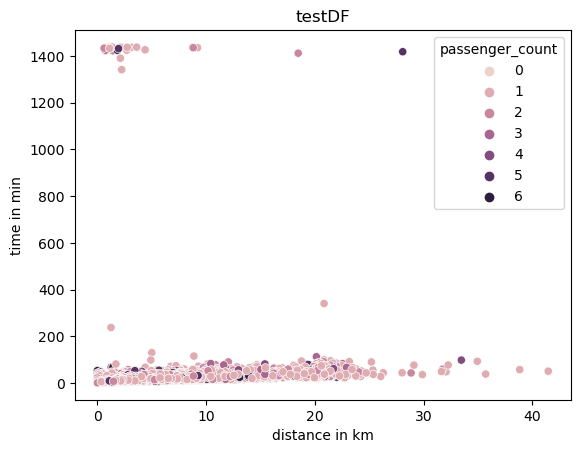

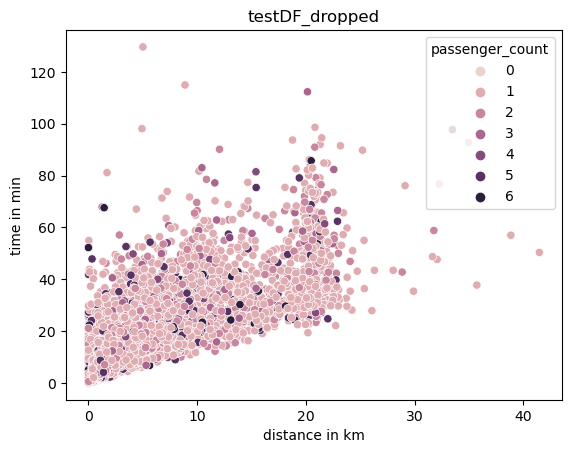

In [11]:
sns.scatterplot(x=testDF['totalDist_km'], y=testDF['timeInMin'], hue=testDF['passenger_count'])

# Set labels and title
plt.xlabel('distance in km')
plt.ylabel('time in min')
plt.title('testDF')

# Show the plot
plt.show()

sns.scatterplot(x=testDF_dropped['totalDist_km'], y=testDF_dropped['timeInMin'], hue=testDF_dropped['passenger_count'])

# Set labels and title
plt.xlabel('distance in km')
plt.ylabel('time in min')
plt.title('testDF_dropped')

# Show the plot
plt.show()

In [12]:
#LINEAR REGRESSION MODEL

#equation: y = Mx + B
#B must be between 6.25 and 6.75
#M must be between 2.1 and 2.2

def trainModel():
    M = round(random.uniform(2.1, 2.2),7)
    B = round(random.uniform(6.25, 6.75),7)
    return M, B

def testModel(df, M, B):
    testNums = []
    for i in range(len(df)):
        actual = df.loc[i, 'timeInMin']
        estimate = M * df.loc[i, 'totalDist_km'] + B
        testNums.append((actual - estimate)**2)
       
    return (sum(testNums) / len(testNums))**0.5

rmseMins_lin = {'rmse':[], 'M':[], 'B':[]}
rmseMins_lin = pd.DataFrame(rmseMins_lin)
for i in range(10):
    rmseNums = {'rmse':[], 'M':[], 'B':[]}
    rmseNums = pd.DataFrame(rmseNums)
    for j in range(10):
        M, B = trainModel()
        rmse = testModel(testDF_dropped, M, B)
        locDF = {'rmse': [rmse], 'M': [M], 'B':[B]}
        locDF = pd.DataFrame(locDF)
        rmseNums = pd.concat([rmseNums, locDF], ignore_index=True)

    minRMSE = min(rmseNums['rmse'])
    minIdx = rmseNums.index[rmseNums['rmse'] == minRMSE]
    rmseMins_lin = pd.concat([rmseMins_lin, rmseNums.loc[minIdx]], ignore_index=True)

In [13]:
rmseMins_lin.head()

,rmse,M,B
0,6.926281,2.109183,6.613864
1,6.927045,2.138284,6.414721
2,6.927180,2.101403,6.572767
3,6.926120,2.126072,6.519212
4,6.925931,2.129592,6.543006


In [14]:
minimum = min(rmseMins_lin['rmse'])
minIdx = rmseMins_lin.index[rmseMins_lin['rmse'] == minimum]
rmseMins_lin.loc[minIdx]

,rmse,M,B
4,6.925931,2.129592,6.543006


In [15]:
#POLYNOMIAL REGRESSION MODEL

#equation: y = A*sqrt(x) + B
#B must be between 0 and 20
#A must be between 5 and 15

def trainModel():
    A = round(random.uniform(5, 15),2)
    B = round(random.uniform(0, 20),2)
    return A, B

def testModel(df, A, B):
    testNums = []
    for i in range(len(df)):
        actual = df.loc[i, 'timeInMin']
        estimate = A * (df.loc[i, 'totalDist_km']**0.5) + B
        testNums.append((actual - estimate)**2)
       
    return (sum(testNums) / len(testNums))**0.5

rmseMins_pol = {'rmse':[], 'A':[], 'B':[]}
rmseMins_pol = pd.DataFrame(rmseMins_pol)
for i in range(10):
    rmseNums = {'rmse':[], 'A':[], 'B':[]}
    rmseNums = pd.DataFrame(rmseNums)
    for j in range(10):
        A, B = trainModel()
        rmse = testModel(testDF_dropped, A, B)
        locDF = {'rmse': [rmse], 'A': [A], 'B':[B]}
        locDF = pd.DataFrame(locDF)
        rmseNums = pd.concat([rmseNums, locDF], ignore_index=True)

    minRMSE = min(rmseNums['rmse'])
    minIdx = rmseNums.index[rmseNums['rmse'] == minRMSE]
    rmseMins_pol = pd.concat([rmseMins_pol, rmseNums.loc[minIdx]], ignore_index=True)

In [16]:
rmseMins_pol.head()

,rmse,A,B
0,14.584365,6.47,15.70
1,8.473634,11.15,0.53
2,7.377304,6.81,3.55
3,9.265814,11.73,0.72
4,7.327889,7.99,2.86


In [17]:
minimum = min(rmseMins_pol['rmse'])
minIdx = rmseMins_pol.index[rmseMins_pol['rmse'] == minimum]
rmseMins_pol.loc[minIdx]

,rmse,A,B
7,7.153076,9.39,0.68
